In [1]:
import os
import shutil

import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import tensorflow as tf

from keras import applications, optimizers, Input
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

%matplotlib inline

Using TensorFlow backend.


In [2]:
def coin_regions(img, x1, y1, x2, y2):
    return img[y1:y2, x1:x2]

In [3]:
def create_dataset(dataset_type):
    """
        createDataset:
        - This script creates dataset with JUST COINS (64x64).
        It's necessary to especify the directory where the full images are stored.
        The directory should contain sub-directories as fallow: '1', '5', '25', '50', '100'
        
        arg:
        - dataset_type:
            0: create train dataset
            1: create test dataset
    """
    
    if dataset_type == 0:
        folder_src = r'../train_durv3'
        folder_out = r'../train_durv4'
    elif dataset_type == 1:
        folder_src = r'../test'
        folder_out = r'../test2'
    
    # hog_detector made with dlib. More trainning improves detection
    detector = dlib.simple_object_detector("hog_detector.svm")
    
    # Create directory to store ONLY COINS
    if os.path.exists('{}'.format(folder_out)):
        shutil.rmtree('{}'.format(folder_out))
    else:
        os.makedirs('{}'.format(folder_out))
    
    # Extract and store coins into right folder
    for coin_directory in os.listdir('{}'.format(folder_src)):
        os.makedirs('{}/{}'.format(folder_out, coin_directory))
        
        train_images_type = []
        for coin_image in os.listdir('{}/{}'.format(folder_src, coin_directory)):
            img = cv2.imread('{}/{}/{}'.format(folder_src, coin_directory, coin_image))
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            blur = cv2.GaussianBlur(gray, (3,3), 2)
            rects = detector(blur)

            if len(rects) > 0:
                left, top, right, bottom = rects[0].left(), rects[0].top(), rects[0].right(), rects[0].bottom()
                coin_region = coin_regions(img, left, top, right, bottom)
                coin_region = np.array(coin_region)
                
                if (coin_region.shape[0] != 0 and coin_region.shape[1] != 0 and coin_region.shape[2] != 0):
                    coin_region = cv2.resize(coin_region,(64,64))
                    train_images_type.append(coin_region)

        for i, image in enumerate(train_images_type):
            cv2.imwrite('{}/{}/{}.jpg'.format(folder_out, coin_directory, i), image)
            
#create_dataset(0)

In [4]:
def create_CNN():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(data_format="channels_last", pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(data_format="channels_last", pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(data_format="channels_last", pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])

    return model

In [5]:
def coins_numbers(coins):
    """
        coins_numbers:
        - return the frequency of a certain coin.
        
        arg:
        - coins: list of images with coin region
    """
    total_coins = {
        '5': 0,
        '10': 0,
        '25': 0,
        '50': 0,
        '100': 0
    }
    
    for coin in coins:
        coin = cv2.resize(coin, (64, 64))
        coin = np.reshape(coin, [1, 64, 64, 3])
        coin = np.asarray(coin)
        
        coin_type = model.predict_classes(coin)
        if coin_type[0] == 0:
            total_coins['10'] += 1
        elif coin_type[0] == 1:
            total_coins['100'] += 1
        elif coin_type[0] == 2:
            total_coins['25'] += 1
        elif coin_type[0] == 3:
            total_coins['5'] += 1
        elif coin_type[0] == 4:
            total_coins['50'] += 1
    
    return total_coins

In [6]:
# Create model, configure train and test dataset
model = create_CNN()

batch_size = 16
train_datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        rescale=1./255,
        zoom_range=0.1,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '../train_durv2',
        target_size=(64, 64),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        '../test_durv2',
        target_size=(64, 64),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode='categorical')

Found 609 images belonging to 5 classes.
Found 35 images belonging to 5 classes.


In [7]:
model.fit_generator(
        train_generator,
        steps_per_epoch=200 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=200 // batch_size)

Epoch 1/50
12/12 [==============================] - 2s 197ms/step - loss: 1.6148 - acc: 0.2552 - val_loss: 1.6061 - val_acc: 0.2000
Epoch 2/50
12/12 [==============================] - 2s 138ms/step - loss: 1.6099 - acc: 0.2188 - val_loss: 1.5746 - val_acc: 0.3714
Epoch 3/50
12/12 [==============================] - 2s 136ms/step - loss: 1.6161 - acc: 0.2760 - val_loss: 1.5249 - val_acc: 0.4571
Epoch 4/50
12/12 [==============================] - 2s 130ms/step - loss: 1.5966 - acc: 0.2975 - val_loss: 1.5880 - val_acc: 0.2286
Epoch 5/50
12/12 [==============================] - 2s 137ms/step - loss: 1.5446 - acc: 0.2969 - val_loss: 1.3987 - val_acc: 0.5143
Epoch 6/50
12/12 [==============================] - 2s 140ms/step - loss: 1.4566 - acc: 0.3958 - val_loss: 1.3897 - val_acc: 0.4286
Epoch 7/50
12/12 [==============================] - 2s 132ms/step - loss: 1.3848 - acc: 0.3565 - val_loss: 1.7115 - val_acc: 0.2000
Epoch 8/50
12/12 [==============================] - 2s 168ms/step - loss: 1.

In [9]:
#model.save('coin_classifier_v1.h5')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 29, 29, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
__________

In [10]:
print(model.evaluate_generator(validation_generator, steps = 32), end='\n\n')
print(train_generator.class_indices)

[0.46606825032652555, 0.799457995549127]

{'10': 0, '100': 1, '25': 2, '5': 3, '50': 4}


In [11]:
def main():
    # hog_detector made with dlib. More trainning improves detection
    detector = dlib.simple_object_detector("hog_detector.svm")

    # show generalized HOG model for a coin
    win_det = dlib.image_window()
    win_det.set_image(detector)
    
    # Processing image input to detect coins on it
    img = cv2.imread('../images/coin8.jpg')[:, :, ::-1]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 2)

    rects = detector(blur)
    
    print('Coins: {}'.format(len(rects)))
    coins = []
    for k, d in enumerate(rects):
        coins.append(coin_regions(img, d.left(), d.top(), d.right(), d.bottom()))

    for coin in coins:
        plt.imshow(coin)
        plt.show()
    
    coins_a = coins_numbers(coins)
    print(coins_a)
    
    plt.imshow(img)
    plt.show()

Coins: 10


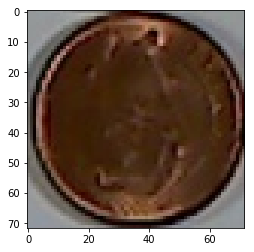

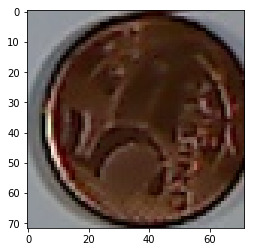

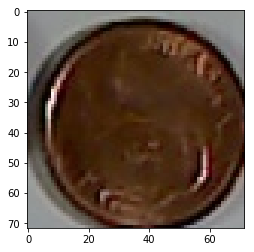

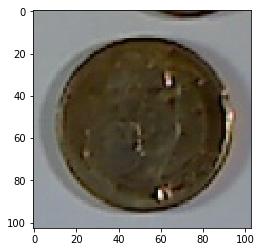

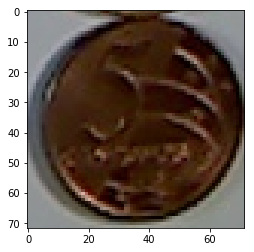

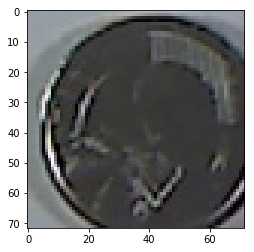

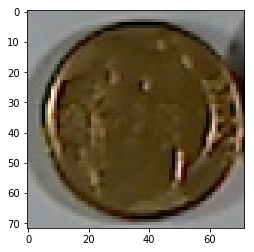

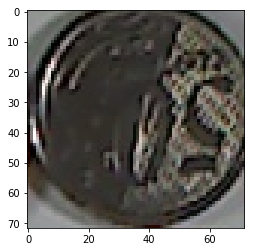

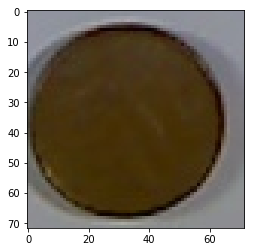

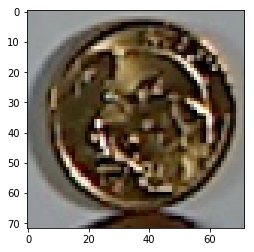

[3]
[3]
[3]
[1]
[3]
[4]
[2]
[4]
[2]
[1]
{'5': 4, '10': 0, '25': 2, '50': 2, '100': 2}


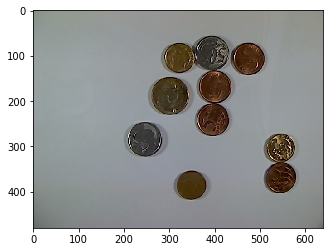

In [12]:
if __name__ == '__main__':
    main()

In [ ]:
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#

In [ ]:
#from keras.preprocessing import image

# Charging image to evaluate in model
#test_image = image.load_img('../moedass3.png', target_size = (64, 64))
#test_image = image.img_to_array(test_image)
#test_image = np.expand_dims(test_image, axis = 0)

#result = model.predict_classes(test_image)
#result

#img = cv2.imread('../exemplo1.jpeg')[:, :, ::-1]
#img = cv2.resize(img,(64,64))
#img = np.reshape(img,[1,64,64,3])
#img = np.asarray(img)

In [ ]:
#def old_create_CNN():
#    classifier = Sequential()
#    
#    classifier.add(Conv2D(32, (5, 5), input_shape = (64, 64, 3), activation = 'relu'))
#    classifier.add(MaxPooling2D(pool_size = (2, 2)))
#
#    classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
#    classifier.add(MaxPooling2D(pool_size = (2, 2)))
#
#    classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
#    classifier.add(MaxPooling2D(pool_size = (2, 2)))
#
#    classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
#    classifier.add(MaxPooling2D(pool_size = (2, 2)))
#
#    classifier.add(Dropout(0.2))
#
#    classifier.add(Flatten())
#    
#    classifier.add(Dense(units = 128, activation = 'relu'))
#    classifier.add(Dense(units = 5, activation = 'softmax'))
#    
#    optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#    classifier.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
#    
#    return classifier

In [ ]:
# OLD VERSION
# Create Convolutional Neural Network and config train and test base
#model = old_create_CNN
#train_datagen = ImageDataGenerator(rotation_range=180,
#                                   width_shift_range=0.2,
#                                   height_shift_range=0.2,
#                                   shear_range=0.05,
#                                   rescale=1/255,
#                                   zoom_range=0.1,
#                                   fill_mode='nearest',
#                                   horizontal_flip = True)

#test_datagen = ImageDataGenerator(rescale = 1./255)

#training_set = train_datagen.flow_from_directory('../train_durv2',
#                                                 target_size = (64, 64),
#                                                 batch_size = 10,
#                                                 class_mode = 'sparse')

#test_set = test_datagen.flow_from_directory('../test2',
#                                            target_size = (64, 64),
#                                            batch_size = 10,
#                                            class_mode = 'sparse')

#classifier.fit_generator(training_set,
#                         steps_per_epoch = 78,
#                         epochs = 30,
#                         validation_data = test_set,
#                         validation_steps = 15)